In [2]:
import json
from collections import Counter

In [3]:
path = '/Users/amycweng/Downloads/CS333_Project/CS333AES/stab'

In [4]:
with open(f'{path}/outputs/asap_set2/optimized_relations.json', "r") as f:
    asap_relations = json.load(f)
with open(f'{path}/outputs/asap_set2/classification_predictions.json',"r") as file: 
    c_predictions = json.load(file)
    
sample = {}
with open(f'{path}/assets/asap_essays.json','r') as file: 
    data = json.load(file) 
count = 0

for name in data:
    count += 1  
    sample[name] = data[name]["text"]
    if count == 400: break

In [5]:
num_relations = []
scores = []
revised_to_premise = 0
revised_to_claim = 0 
outgoing_relations = {} # key is essay, value is dictionary mapping each component to its outgoing relations
incoming_relations = {} # key is essay, value is dictionary mapping each component to its incoming relations
component_info = {} # key is essay, value is dictionary that maps each component index to its optimized type 
c_idx = 0 
label_to_type = {0: "MajorClaim", 1: "Claim", 2: "Premise"}
for essay in sample:
    essay_name = essay + ".txt"
    outgoing_relations[essay_name] = {}
    incoming_relations[essay_name] = {}
    num_relations.append(len(asap_relations[essay_name]['relations'].keys()))
    scores.append(data[essay]['domain1_score'])
    with open(f'{path}/outputs/asap_set2/classification/{essay_name}.json','r') as file: 
        components = json.load(file)

    for pair in asap_relations[essay_name]['relations'].keys(): 
        pair = pair.split(",")
        source,target = int(pair[0]),int(pair[1])
        outgoing_relations[essay_name][source] = target
        incoming_relations[essay_name][target] = source
    
    for c in components:
        index = c["index"] 
        if essay_name not in component_info: 
            component_info[essay_name] = {}
        component_info[essay_name][index] = "Premise" # default is premise. Only components without outgoing relations are claims 
        if index not in outgoing_relations[essay_name]: 
            component_info[essay_name][index] = "Claim"
        optimized_type = component_info[essay_name][index]
        predicted_type = label_to_type[c_predictions[c_idx]]
        c_idx += 1 
        if optimized_type != predicted_type:
            if predicted_type == "Premise": 
                revised_to_premise += 1 
            elif predicted_type == "Premise" and optimized_type == "Claim": 
                revised_to_claim += 1 

In [6]:
print(f"ILP revised {revised_to_premise} claims to premises.")
print(f"ILP revised {revised_to_claim} premises to claims.")
print(f"There are {sum(num_relations)} relations and {sum([len(c.keys()) for c in component_info.values()])} components in total")

ILP revised 1401 claims to premises.
ILP revised 0 premises to claims.
There are 4156 relations and 5868 components in total


In [7]:
# scoring based on the ratio of supported claims in each essay
tree_scores = []
for essay in sample:
    essay_name = essay + ".txt"
    num_claims = 0 
    supported = 0
    if essay_name not in component_info: 
        tree_scores.append(0)
        continue
    for c,type in component_info[essay_name].items(): 
        if type == "Claim": 
            num_claims += 1 
            if c in incoming_relations[essay_name]: 
                supported += 1 
    tree_scores.append(supported / num_claims)
    

In [8]:
import matplotlib.pyplot as plt

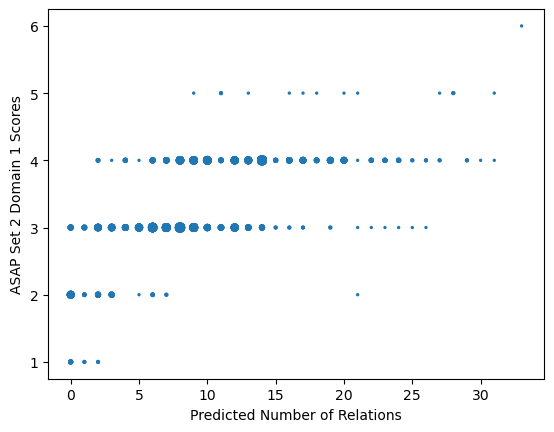

In [9]:
plt.xlabel("Predicted Number of Relations")
plt.ylabel("ASAP Set 2 Domain 1 Scores")
X = num_relations
Y = scores
c = Counter(zip(X,Y))
S = [2*c[(x,y)] for x,y in zip(X,Y)]
plt.scatter(X, Y,s=S)

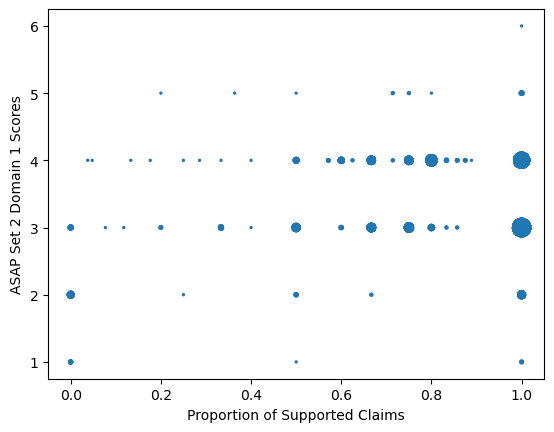

In [11]:
plt.xlabel("Proportion of Supported Claims")
plt.ylabel("ASAP Set 2 Domain 1 Scores")
X = tree_scores
Y = scores
c = Counter(zip(X,Y))
S = [2*c[(x,y)] for x,y in zip(X,Y)]
plt.scatter(X, Y,s=S)

In [12]:
import statsmodels.api as sm

In [15]:
model = sm.OLS(num_relations, scores)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.786
Method:                 Least Squares   F-statistic:                              1469.
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                   7.80e-136
Time:                        17:08:38   Log-Likelihood:                         -1267.9
No. Observations:                 400   AIC:                                      2538.
Df Residuals:                     399   BIC:                                      2542.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [16]:
model = sm.OLS(tree_scores, scores)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                              2626.
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                   1.33e-177
Time:                        17:08:45   Log-Likelihood:                         -79.911
No. Observations:                 400   AIC:                                      161.8
Df Residuals:                     399   BIC:                                      165.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------